In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import InterpolatedUnivariateSpline
import random
import seaborn as sns
from shapely.geometry import Point

import vdmlab as vdm

from load_data import get_pos, get_spikes, get_lfp
# from tuning_curves_functions import get_tc_1d
from field_functions import get_unique_fields
from maze_functions import trajectory_fields, find_zones
from plotting_functions import plot_cooccur

import info.R063d2_info as r063d2
import info.R063d3_info as r063d3

In [2]:
# pickle_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\cache\\pickled\\'
# output_filepath = 'C:\\Users\\Emily\\Code\\emi_shortcut\\plots\\'
output_filepath = 'E:\\code\\emi_shortcut\\cache\\pickled\\'
output_filepath = 'E:\\code\\emi_shortcut\\plots\\'

In [223]:
infos = [r063d3]
experiment_times = ['pauseA']

for info in infos:
    print(info.session_id)
    for experiment_time in experiment_times:
        print(experiment_time)
        
        lfp = get_lfp(info.good_swr[0])
        position = get_pos(info.pos_mat, info.pxl_to_cm)
        spikes = get_spikes(info.spike_mat)

        speed = position.speed(t_smooth=0.5)
        run_idx = np.squeeze(speed.data) >= info.run_threshold
        run_pos = position[run_idx]

        t_start = info.task_times[experiment_time].start
        t_stop = info.task_times[experiment_time].stop
        
        sliced_lfp = lfp.time_slice(t_start, t_stop)
        
        sliced_spikes = [spiketrain.time_slice(t_start, t_stop) for spiketrain in spikes]
        
        t_start_tc = info.task_times['phase3'].start
        t_stop_tc = info.task_times['phase3'].stop
        
        tc_pos = run_pos.time_slice(t_start_tc, t_stop_tc)

        tc_spikes = [spiketrain.time_slice(t_start_tc, t_stop_tc) for spiketrain in spikes]

        binsize = 3
        xedges = np.arange(tc_pos.x.min(), tc_pos.x.max() + binsize, binsize)
        yedges = np.arange(tc_pos.y.min(), tc_pos.y.max() + binsize, binsize)

        tuning_curves = vdm.tuning_curve_2d(tc_pos, tc_spikes, xedges, yedges, gaussian_sigma=0.1)
        
        zones = find_zones(info)
        
#         fields_tc, fields_spikes = trajectory_fields(tuning_curves, tc_spikes, zones, xedges, yedges, field_thresh=1.)

        fields_tunings = categorize_fields(tuning_curves, zones, xedges, yedges, field_thresh=5.)
        
        keys = ['u', 'shortcut', 'novel']
        unique_fields = dict()
        unique_fields['u'] = get_unique_fields(fields_tunings['u'], fields_tunings['shortcut'], fields_tunings['novel'])
        unique_fields['shortcut'] = get_unique_fields(fields_tunings['shortcut'], fields_tunings['novel'], fields_tunings['u'])
        unique_fields['novel'] = get_unique_fields(fields_tunings['novel'], fields_tunings['u'], fields_tunings['shortcut'])

        field_spikes = dict(u=[], shortcut=[], novel=[])
        for field in field_spikes:
            for key in fields:
                field_spikes[field].append(spikes[key])

        swrs = vdm.detect_swr_hilbert(sliced_lfp, fs=info.fs, thresh=(140.0, 250.0), power_thres=5)
        
        swr_intervals = []
        for swr in swrs:
            swr_intervals.append([swr.time[0], swr.time[-1]])
        swr_intervals = np.array(swr_intervals).T         
                
        count_matrix = dict()
        for key in fields_spikes:
            count_matrix[key] = vdm.spike_counts(fields_spikes[key], swr_intervals, window=0.1)
            
        tetrode_mask = dict()
        for key in fields_spikes:
            tetrode_mask[key] = vdm.get_tetrode_mask(fields_spikes[key])
        
        probs = dict()
        for key in fields_spikes:
            probs[key] = vdm.compute_cooccur(count_matrix[key], tetrode_mask[key], num_shuffles=10000)
            
        filename = 'testing_cooccur-' + experiment_time + '.png'
        savepath = os.path.join(output_filepath, filename)
        plot_cooccur(probs, savepath=None)

R063d3
pauseA


NameError: name 'get_unique_fields' is not defined

In [4]:
len(fields_spikes['u']), len(fields_spikes['shortcut']), len(fields_spikes['novel'])

(110, 100, 84)

In [ ]:
len(fields_neuron['u']), len(fields_neuron['shortcut']), len(fields_neuron['novel']), len(fields_neuron['pedestal'])

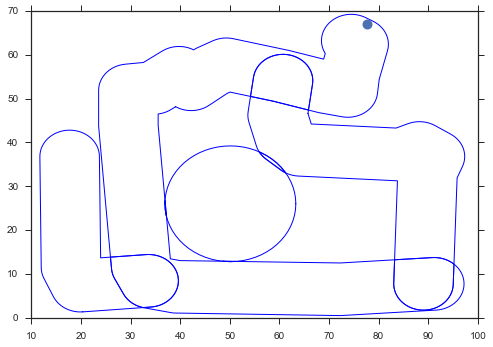

In [89]:
from plotting_functions import plot_intersects, plot_zone

for zone in zones:
    if zones[zone].geom_type == 'MultiPolygon':
        plot_intersects(zones[zone])
    elif zones[zone].geom_type == 'Polygon':
        plot_zone(zones[zone])
    else:
        continue

plt.plot(77.56975984316288, 66.92093904767174, '.', ms=20)

In [57]:
from scipy.ndimage import filters
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
def find_fields_2d(tuning_curves, neighborhood_size, threshold):
    fields_mask = []
    for tuning_curve in tuning_curves:
        max_points = filters.maximum_filter(tuning_curve, neighborhood_size)
        maxima = (tuning_curve == max_points)
        min_points = filters.minimum_filter(tuning_curve, neighborhood_size)
        diff = ((max_points - min_points) > threshold)
        maxima[diff == 0] = 0
        fields_mask.append(maxima)
    return fields_mask

In [58]:
neighborhood_size = 2
threshold = 0.1
fields_mask = find_fields_2d(tuning_curves, neighborhood_size, threshold)

In [187]:
from scipy import ndimage

def get_field_mask(tuning_curves, field_thresh):
    """Finds mask for field detection from 2D tuning curves.
    
    Parameters
    ----------
    tuning_curves: list of np.arrays
        Where each inner array is the tuning curve for an individual neuron.
    field_thresh: float
    
    Returns
    -------
    field_mask: list of bool arrays
    
    """
    field_mask = []
    
    for tuning_curve in tuning_curves:
        mask = tuning_curve > field_thresh

        # Remove noise
        open_field = ndimage.binary_opening(mask)
        field_mask.append(ndimage.binary_closing(open_field))

    return field_mask


def categorize_fields(tuning_curves, zone, xedges, yedges, field_thresh):
    """Sorts tuning curves into zones based on peak tuning.
    
    Parameters
    ----------
    tuning_curves: list of np.arrays
        Where each inner array is the tuning curve for an individual neuron.
    zone: dict
        With u, ushort, unovel, shortcut, shortped, novel, novelped, pedestal keys.
        Each contains a shapely.Polygon object as values.
    xedges: np.array
    yedges: np.array
    field_thresh: float
    
    Returns
    -------
    fields_tc: dict
        With u, shortcut, novel (dict) as keys.
        Each inner dict contains the index for the neuron as a key and 
        the tuning curve as the value.
    """
    
    field_masks = get_field_mask(tuning_curves, field_thresh)
    
    xcenters = (xedges[1:] + xedges[:-1]) / 2.
    ycenters = (yedges[1:] + yedges[:-1]) / 2.

    xy_centers = vdm.cartesian(xcenters, ycenters)

    fields_tc = dict(u=dict(), shortcut=dict(), novel=dict(), pedestal=dict())
    
    for i, field_mask in enumerate(field_masks):
        field = xy_centers[np.ravel(field_mask)]
        
        for pt in field:
            point = Point([pt[0], pt[1]])
            if (i not in fields_tc['u']) and (zone['u'].contains(point) or 
                                              zone['ushort'].contains(point) or 
                                              zone['unovel'].contains(point)):
                fields_tc['u'][i] = tuning_curves[i]
                
            if (i not in fields_tc['shortcut']) and (zone['shortcut'].contains(point) or 
                                                     zone['shortped'].contains(point)):
                fields_tc['shortcut'][i] = tuning_curves[i]
                
            if (i not in fields_tc['novel']) and (zone['novel'].contains(point) or 
                                                  zone['novelped'].contains(point)):
                    fields_tc['novel'][i] = tuning_curves[i]
    return fields_tc

In [208]:
field_thresh = 5.
field_masks = get_field_mask(tuning_curves, field_thresh)

In [209]:
fields_tunings = categorize_fields(tuning_curves, zones, xedges, yedges, field_thresh)

In [210]:
len(fields_tunings['u']), len(fields_tunings['shortcut']), len(fields_tunings['novel']), len(fields_tunings['pedestal'])

(26, 27, 14, 0)

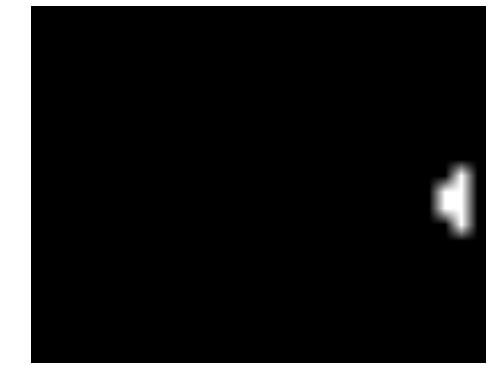

In [200]:
field_mask = field_masks[8]
l=500

plt.imshow(field_mask[:l, :l], cmap=plt.cm.gray)
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
plt.show()

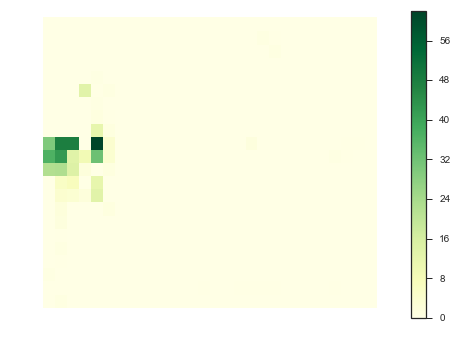

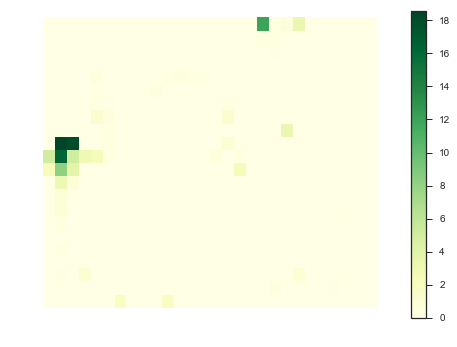

In [219]:
plt.figure()
xx, yy = np.meshgrid(xedges, yedges)
u_keys = novel_fields_unique.keys()
for key in u_keys:
    pp = plt.pcolormesh(xx, yy, fields_tunings['novel'][key], cmap='YlGn')
    plt.colorbar(pp)
    plt.axis('off')
    plt.show()

In [174]:
fields_tunings['u'].keys()

dict_keys([64, 3, 68, 7, 74, 11, 14, 82, 83, 85, 22, 23, 25, 71, 93, 30, 95, 97, 113, 37, 103, 43, 109, 47, 48, 49, 115, 53, 54, 55, 87, 61])

In [222]:
from field_functions import get_unique_fields
keys = ['u', 'shortcut', 'novel']
unique_fields = dict()
unique_fields['u'] = get_unique_fields(fields_tunings['u'], fields_tunings['shortcut'], fields_tunings['novel'])
unique_fields['shortcut'] = get_unique_fields(fields_tunings['shortcut'], fields_tunings['novel'], fields_tunings['u'])
unique_fields['novel'] = get_unique_fields(fields_tunings['novel'], fields_tunings['u'], fields_tunings['shortcut'])

field_spikes = dict(u=[], shortcut=[], novel=[])
for field in field_spikes:
    for key in fields:
        field_spikes[field].append(spikes[key])

ImportError: cannot import name 'get_unique_fields'

In [220]:
keys

NameError: name 'keys' is not defined